# Finite-element mode solver

You can mesh any component cross-section and solve the PDEs thanks to `femwell` mode - solver.

Unlike other mode solvers, this actually uses the component geometry instead of a hardcoded geometry.

You can directly compute the modes of a Gdsfactory cross-section (internally, it defines a "uz" mesh  perpendicular to a straight component with the provided cross-section).

You can also downsample layers from the LayerStack, and modify both the cross-section and LayerStack  prior to simulation to change the geometry. You can also define refractive indices on the active PDK.

In [1]:
%%capture
from gdsfactory.simulation.fem.mode_solver import compute_cross_section_modes
from gdsfactory.tech import LayerStack, get_layer_stack_generic
from gdsfactory.cross_section import rib

filtered_layerstack = LayerStack(
    layers={
        k: get_layer_stack_generic().layers[k]
        for k in (
            "core",
            "clad",
            "slab90",
            "box",
        )
    }
)

filtered_layerstack.layers[
    "core"
].thickness = 0.2  # Perturb the layerstack before simulating

resolutions = {}
resolutions["core"] = {"resolution": 0.02, "distance": 2}
resolutions["clad"] = {"resolution": 0.2, "distance": 1}
resolutions["box"] = {"resolution": 0.2, "distance": 1}
resolutions["slab90"] = {"resolution": 0.05, "distance": 1}

lams, basis, xs = compute_cross_section_modes(
    cross_section=rib(width=0.6),
    layerstack=filtered_layerstack,
    wl=1.55,
    num_modes=4,
    resolutions=resolutions,
)

The solver returns the effective indices (lams), FEM basis functions (basis) and eigenvectors (xs):

In [2]:
lams, basis, xs

(
    array([2.51200907-3.59315701e-09j, 2.48312844-8.85128771e-09j,
       2.44855365-1.74778797e-09j, 2.08113838-6.56469707e-09j]),
    <skfem CellBasis(MeshTri1, ElementComposite) object>
  Number of elements: 10486
  Number of DOFs: 21133
  Size: 48319488 B,
    array([[-1.85320187e-01-5.89343325e-02j, -3.79001282e-01-1.20527559e-01j,
        -2.86461929e-01-9.10987902e-02j, ...,
         1.16267271e-08-3.61026620e-08j,  5.78195273e-09-1.57804943e-08j,
        -5.14682950e-10-2.92241157e-10j],
       [-1.32254958e-01+3.24530208e-03j,  3.83459048e-01-9.40865148e-03j,
         3.74499202e-01-9.18887969e-03j, ...,
         1.17763003e-09+4.64877029e-08j, -1.33742185e-09-2.78146889e-08j,
         5.42244939e-10+4.03023718e-10j],
       [ 5.77074636e-02+6.11724358e-02j, -2.84307496e-01-3.01378237e-01j,
        -2.51004155e-01-2.66075260e-01j, ...,
        -5.27707910e-08+4.98777628e-08j, -3.15444439e-08+2.73964693e-08j,
        -2.24777325e-10+6.57416978e-11j],
       [ 2.45052668e-02+3.89178160e-03j, -2.82389309e-02-4.48479441e-03j,
        -3.41712062e-02-5.42691954e-03j, ...,
        -8.83233278e-05+5.56133222e-04j,  1.28199123e-03-8.07220957e-03j,
        -6.65497836e-08+4.19567795e-07j]])
)

You can use them as inputs to other [femwell mode solver functions](https://github.com/HelgeGehring/femwell/blob/main/femwell/mode_solver.py) to inspect or analyze the modes:

In [3]:
%%capture
from femwell import mode_solver
import numpy as np

fig = mode_solver.plot_mode(
    basis, np.real(xs[0]), plot_vectors=False, colorbar=True, title="E", direction="y"
)

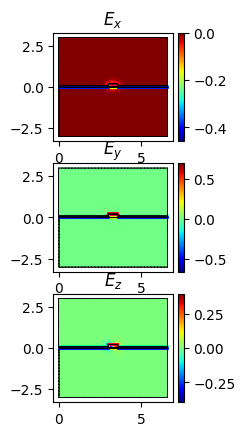

In [4]:
fig[0]

In [5]:
%%capture
te_frac = mode_solver.calculate_te_frac(basis, xs[0])

In [6]:
te_frac

0.9676672158113578

## Sweep waveguide width

In [7]:
%%capture
from tqdm.auto import tqdm
import gdsfactory as gf
from femwell import mode_solver
import numpy as np
import matplotlib.pyplot as plt

widths = np.linspace(0.2, 2, 20)
num_modes = 4
all_lams = np.zeros((widths.shape[0], num_modes))
all_te_fracs = np.zeros((widths.shape[0], num_modes))

for i, width in enumerate(tqdm(widths)):
    lams, basis, xs = compute_cross_section_modes(
        cross_section=gf.cross_section.strip(width=width),
        layerstack=filtered_layerstack,
        wl=1.55,
        num_modes=num_modes,
        resolutions=resolutions,
    )
    all_lams[i] = lams
    all_te_fracs[i, :] = [
        mode_solver.calculate_te_frac(basis, xs[idx]) for idx in range(num_modes)
    ]

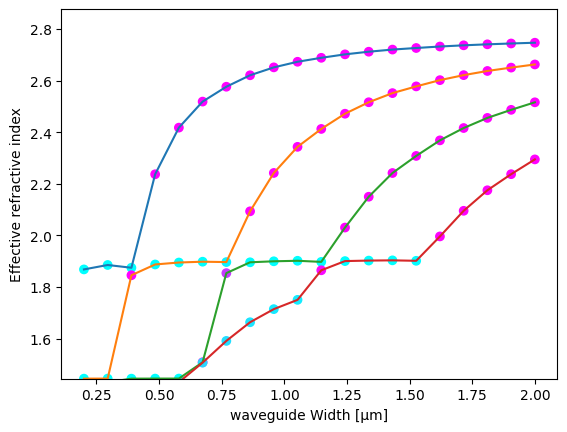

In [8]:
all_lams = np.real(all_lams)
plt.xlabel("waveguide Width [µm]")
plt.ylabel("Effective refractive index")
plt.ylim(1.444, np.max(all_lams) + 0.1 * (np.max(all_lams) - 1.444))

for lams, te_fracs in zip(all_lams.T, all_te_fracs.T):
    plt.plot(widths, lams)
    plt.scatter(widths, lams, c=te_fracs, cmap="cool")